# Ingest

## Libraries

In [84]:
import os, cv2, random, shutil
import numpy as np
import pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split


## Load Data

In [42]:
uploaded = files.upload()

Saving kaggle.json to kaggle (2).json


In [43]:
!pwd

/content


In [44]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

train.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [46]:
!mkdir train_img
!mkdir test_img

In [47]:
!unzip train.zip -d train_img

Streaming output truncated to the last 5000 lines.
  inflating: train_img/train/dog.5499.jpg  
  inflating: train_img/train/dog.55.jpg  
  inflating: train_img/train/dog.550.jpg  
  inflating: train_img/train/dog.5500.jpg  
  inflating: train_img/train/dog.5501.jpg  
  inflating: train_img/train/dog.5502.jpg  
  inflating: train_img/train/dog.5503.jpg  
  inflating: train_img/train/dog.5504.jpg  
  inflating: train_img/train/dog.5505.jpg  
  inflating: train_img/train/dog.5506.jpg  
  inflating: train_img/train/dog.5507.jpg  
  inflating: train_img/train/dog.5508.jpg  
  inflating: train_img/train/dog.5509.jpg  
  inflating: train_img/train/dog.551.jpg  
  inflating: train_img/train/dog.5510.jpg  
  inflating: train_img/train/dog.5511.jpg  
  inflating: train_img/train/dog.5512.jpg  
  inflating: train_img/train/dog.5513.jpg  
  inflating: train_img/train/dog.5514.jpg  
  inflating: train_img/train/dog.5515.jpg  
  inflating: train_img/train/dog.5516.jpg  
  inflating: train_img/train/

In [48]:
!unzip test.zip -d test_img/

Streaming output truncated to the last 5000 lines.
  inflating: test_img/test/5499.jpg  
  inflating: test_img/test/55.jpg    
  inflating: test_img/test/550.jpg   
  inflating: test_img/test/5500.jpg  
  inflating: test_img/test/5501.jpg  
  inflating: test_img/test/5502.jpg  
  inflating: test_img/test/5503.jpg  
  inflating: test_img/test/5504.jpg  
  inflating: test_img/test/5505.jpg  
  inflating: test_img/test/5506.jpg  
  inflating: test_img/test/5507.jpg  
  inflating: test_img/test/5508.jpg  
  inflating: test_img/test/5509.jpg  
  inflating: test_img/test/551.jpg   
  inflating: test_img/test/5510.jpg  
  inflating: test_img/test/5511.jpg  
  inflating: test_img/test/5512.jpg  
  inflating: test_img/test/5513.jpg  
  inflating: test_img/test/5514.jpg  
  inflating: test_img/test/5515.jpg  
  inflating: test_img/test/5516.jpg  
  inflating: test_img/test/5517.jpg  
  inflating: test_img/test/5518.jpg  
  inflating: test_img/test/5519.jpg  
  inflating: test_img/test/552.jpg   

# EDA

## First Look at Data

In [63]:
# Inspired by Jeff Delaney notebook: https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter

def get_images (directory, type=None):
    if type is None:
        images = [directory + i for i in os.listdir(directory)]
        print(f"There are {len(images)} images")
    else:
        images = [directory + i for i in os.listdir(directory) if type in i]
        print(f"There are {len(images)} {type} images")
    return images

train = '/content/train_img/train/'
test = '/content/test_img/test/'

train_images = get_images(train)
train_dogs = get_images(train, 'dog')
train_cats = get_images(train, 'cat')
test_images = get_images(test)

There are 25000 images
There are 12500 dog images
There are 12500 cat images
There are 12500 images


## Sectioning Data

In [66]:
train_images = random.sample(train_dogs, 2000) + random.sample(train_cats, 2000)
random.shuffle(train_images)

In [68]:
hmm = train_images[1]
hmm[24:]


'/cat.11158.jpg'

In [72]:
!mkdir train_subset

In [73]:
for file in train_images:
    shutil.copy(file, f"/content/train_subset/{file[24:]}")

In [74]:
ROWS = 64
COLS = 64
CHANNELS = 3

In [75]:
def read_image (file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


In [76]:
def read_image (file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    
    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print (f"Processed {i} of {count}")
    return data

train = prep_data(train_images)
print(f"Train shape {train.shape}")

Processed 0 of 4000
Processed 250 of 4000
Processed 500 of 4000
Processed 750 of 4000
Processed 1000 of 4000
Processed 1250 of 4000
Processed 1500 of 4000
Processed 1750 of 4000
Processed 2000 of 4000
Processed 2250 of 4000
Processed 2500 of 4000
Processed 2750 of 4000
Processed 3000 of 4000
Processed 3250 of 4000
Processed 3500 of 4000
Processed 3750 of 4000
Train shape (4000, 3, 64, 64)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


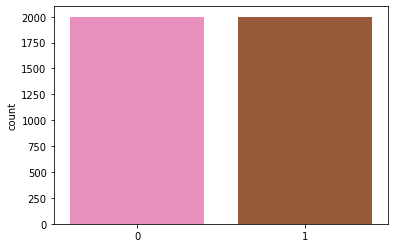

In [90]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.set_palette('Set1_r')
sns.countplot(labels)